## Import necessary libraries
---



---

In [4]:
# For data manipulation and analysis
import pandas as pd
import numpy as np

# For plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For text processing and manipulation
import re
from wordcloud import WordCloud, STOPWORDS

# For sentiment analysis
from textblob import TextBlob

# For machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

# For deep learning and transformers
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
import torch.nn.functional as F
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

# For progress bar
from tqdm import tqdm

# Others
from collections import Counter
from nltk.util import ngrams


## Loading the data
---



---

In [5]:
data = pd.read_csv('/Users/pranavkhot/Documents/NLP/data/processed_data/final_data.csv')
data.head(10)

,created_at,text,favourites_count,retweet_count,polarity,sentiment,tweet_length
0,0.066667,covid19 socialdistancing the indian way,10374,0,0.00000,neutral,39
1,0.066667,possible case of human to animal transmission ...,22880,0,-0.23125,negative,219
2,0.116667,coronavirus us eclipses 120 000 confirmed case...,12968,6,0.40000,positive,78
3,0.150000,the bitter truth covid 19 covid19india lockdow...,6,0,-0.10000,negative,53
4,0.216667,coronavirusoutbreak all churches shd realize t...,38,0,0.13750,positive,272
5,0.233333,coronaupdate italy 10000 usa 2200 amp worldwid...,5,0,-0.12500,negative,254
6,0.266667,death count on march 28th 2020 1 italy 889 mor...,12547,6,0.25000,positive,208
7,0.283333,very unfortunate to see this unplanned ill int...,236,0,-0.57500,negative,104
8,0.383333,two weeks ago and today coronaupdate coronaloc...,2598,1,0.00000,neutral,63
9,0.583333,i have made a small contribution towards my co...,48715,1,-0.25000,negative,211


In [6]:
print(data['sentiment'].unique())


['neutral' 'negative' 'positive']


## Map labels to integers
___
___

In [7]:
label_map = {'positive': 2, 'neutral': 1, 'negative': 0}
data['sentiment'] = data['sentiment'].map(label_map)
data.head()


,created_at,text,favourites_count,retweet_count,polarity,sentiment,tweet_length
0,0.066667,covid19 socialdistancing the indian way,10374,0,0.00000,1,39
1,0.066667,possible case of human to animal transmission ...,22880,0,-0.23125,0,219
2,0.116667,coronavirus us eclipses 120 000 confirmed case...,12968,6,0.40000,2,78
3,0.150000,the bitter truth covid 19 covid19india lockdow...,6,0,-0.10000,0,53
4,0.216667,coronavirusoutbreak all churches shd realize t...,38,0,0.13750,2,272


## Data Splitting
---



---

In [8]:
# Splitting the data
X = data['text']
y = data['sentiment']

# Using TF-IDF Vectorizer to convert text data into numerical format
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(X)

# Splitting into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape
data.head()

,created_at,text,favourites_count,retweet_count,polarity,sentiment,tweet_length
0,0.066667,covid19 socialdistancing the indian way,10374,0,0.00000,1,39
1,0.066667,possible case of human to animal transmission ...,22880,0,-0.23125,0,219
2,0.116667,coronavirus us eclipses 120 000 confirmed case...,12968,6,0.40000,2,78
3,0.150000,the bitter truth covid 19 covid19india lockdow...,6,0,-0.10000,0,53
4,0.216667,coronavirusoutbreak all churches shd realize t...,38,0,0.13750,2,272


## BERT Tokenization

---
---

In [9]:
# Importing the transformers library to use BERT tokenizer
from transformers import BertTokenizer

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to tokenize and encode sequences in the dataset
def bert_encode_text(text, tokenizer, max_len):
    tokens = tokenizer.batch_encode_plus(
        text,
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors='pt'  # PyTorch tensors
    )
    return tokens


# Maximum length for padding and truncation
max_len = 64  # You can change this based on your needs

# Tokenize and encode the 'text' column in the dataset
encoded_text = bert_encode_text(data['text'], tokenizer, max_len)

# Display the keys in the encoded dictionary
encoded_text.keys()
data.head()

,created_at,text,favourites_count,retweet_count,polarity,sentiment,tweet_length
0,0.066667,covid19 socialdistancing the indian way,10374,0,0.00000,1,39
1,0.066667,possible case of human to animal transmission ...,22880,0,-0.23125,0,219
2,0.116667,coronavirus us eclipses 120 000 confirmed case...,12968,6,0.40000,2,78
3,0.150000,the bitter truth covid 19 covid19india lockdow...,6,0,-0.10000,0,53
4,0.216667,coronavirusoutbreak all churches shd realize t...,38,0,0.13750,2,272


## Dataset Creation for BERT
___
___

In [10]:
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset, random_split

# Check for NaN in 'sentiment' column and handle them
assert not pd.isna(data['sentiment']).any(), "NaN values in labels detected!"

# Initialize pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3  
)

# Set hyperparameters and create DataLoader
batch_size = 32  
dataset = TensorDataset(
    encoded_text['input_ids'],
    encoded_text['attention_mask'],
    torch.tensor(data['sentiment'].values).long()
)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(data['sentiment'].unique())


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[1 0 2]


## Model Training
___
___

In [11]:
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import torch

# Check for NaN in 'sentiment' column and handle them
assert not pd.isna(data['sentiment']).any(), "NaN values in labels detected!"

# Initialize pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3  
)

# Set hyperparameters
batch_size = 32  

# Create PyTorch DataLoader
dataset = TensorDataset(
    encoded_text['input_ids'],
    encoded_text['attention_mask'],
    torch.tensor(data['sentiment'].values).long()  # Convert to long integers
)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Now batch_size is defined
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # Now batch_size is defined


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Model Evaluation and Prediction
___
___

In [12]:
from transformers import BertForSequenceClassification

# Initialize BERT model for sequence classification with 3 classes
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3  
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
from sklearn.metrics import accuracy_score
from transformers import AdamW
from tqdm import tqdm

# Initialize optimizer and set epochs
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
epochs = 3

# Lists to hold the losses
train_losses = []
val_losses = []

# Initialize variables to hold best validation accuracy and corresponding epoch
best_val_acc = 0
best_epoch = 0

# Training loop
model.train()
for epoch in range(epochs):
    for step, batch in enumerate(tqdm(train_dataloader)):
        # Load batch to CPU
        b_input_ids, b_input_mask, b_labels = tuple(t.to('cpu') for t in batch)
        
        # Zero out any previously calculated gradients
        model.zero_grad()
        
        # Forward pass
        output = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = output[0]
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
    # Validation loop
    model.eval()
    val_loss = []
    val_acc = []
    for batch in val_dataloader:
        # Load batch to CPU
        b_input_ids, b_input_mask, b_labels = tuple(t.to('cpu') for t in batch)
        
        with torch.no_grad():
            output = model(b_input_ids, attention_mask=b_input_mask)
        
        logits = output[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        val_loss.append(loss.item())
        val_acc.append(accuracy_score(label_ids, np.argmax(logits, axis=1).flatten()))
    
    # Calculate and print average validation loss and accuracy
    avg_val_loss = np.mean(val_loss)
    avg_val_acc = np.mean(val_acc)
    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation Accuracy: {avg_val_acc}")
    
    # Update best validation accuracy and epoch
    if avg_val_acc > best_val_acc:
        best_val_acc = avg_val_acc
        best_epoch = epoch

# Save the fine-tuned model
model.save_pretrained("fine_tuned_BERT1")
print(f"Best Validation Accuracy: {best_val_acc} at epoch {best_epoch}")

100%|██████████| 1010/1010 [34:52<00:00,  2.07s/it] 


Validation Loss: 0.02391323819756508
Validation Accuracy: 0.9452816205533597


100%|██████████| 1010/1010 [23:33<00:00,  1.40s/it]


Validation Loss: 0.031622011214494705
Validation Accuracy: 0.9567687747035574


100%|██████████| 1010/1010 [23:07<00:00,  1.37s/it]


Validation Loss: 0.031534790992736816
Validation Accuracy: 0.9635622529644269
Best Validation Accuracy: 0.9635622529644269 at epoch 2


## Model Evaluation and Prediction
___
___

In [14]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("fine_tuned_BERT1")


In [15]:
from torch.utils.data import Subset
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Create a test DataLoader from a subset of the validation data
test_size = int(0.2 * len(val_dataloader.dataset))  # 20% of validation data
indices = np.random.choice(len(val_dataloader.dataset), test_size, replace=False)
test_dataset = Subset(val_dataloader.dataset, indices)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


╒══════════════╤═════════════╤══════════╤════════════╤════════════╕
│              │   precision │   recall │   f1-score │    support │
╞══════════════╪═════════════╪══════════╪════════════╪════════════╡
│ 0            │    0.877193 │ 0.915751 │   0.896057 │  273       │
├──────────────┼─────────────┼──────────┼────────────┼────────────┤
│ 1            │    0.97191  │ 0.96648  │   0.969188 │  537       │
├──────────────┼─────────────┼──────────┼────────────┼────────────┤
│ 2            │    0.969849 │ 0.959006 │   0.964397 │  805       │
├──────────────┼─────────────┼──────────┼────────────┼────────────┤
│ accuracy     │    0.95418  │ 0.95418  │   0.95418  │    0.95418 │
├──────────────┼─────────────┼──────────┼────────────┼────────────┤
│ macro avg    │    0.939651 │ 0.947079 │   0.943214 │ 1615       │
├──────────────┼─────────────┼──────────┼────────────┼────────────┤
│ weighted avg │    0.954872 │ 0.95418  │   0.954438 │ 1615       │
╘══════════════╧═════════════╧══════════╧═══════

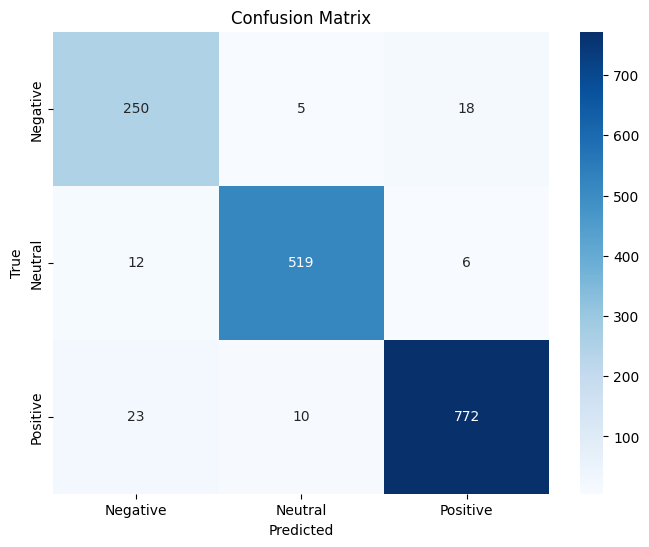

Accuracy Score: 0.9541795665634675


In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluation loop
model.eval()
predictions, true_labels = [], []

for batch in test_dataloader:
    b_input_ids, b_input_mask, b_labels = tuple(t.to('cpu') for t in batch)
    
    with torch.no_grad():
        output = model(b_input_ids, attention_mask=b_input_mask)
    
    logits = output[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(np.argmax(logits, axis=1).flatten())
    true_labels.append(label_ids)

# Flatten the predictions and true values for aggregate classification report
predictions = np.concatenate(predictions)
true_labels = np.concatenate(true_labels)

# Print classification report
report = classification_report(true_labels, predictions, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report).transpose()

# Tabulate
report_table = tabulate(report_df, headers='keys', tablefmt='fancy_grid', showindex=True)
print(report_table)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
print("Accuracy Score:", accuracy_score(true_labels, predictions))


## User Interaction for Sentiment Prediction
___
___

       Sentiment Analysis
Input Sentence: BackBack Mumbai heatwave alert: IMD issues warnings for financial capital & neighbouring districts from April 27-29
Predicted Sentiment: Neutral


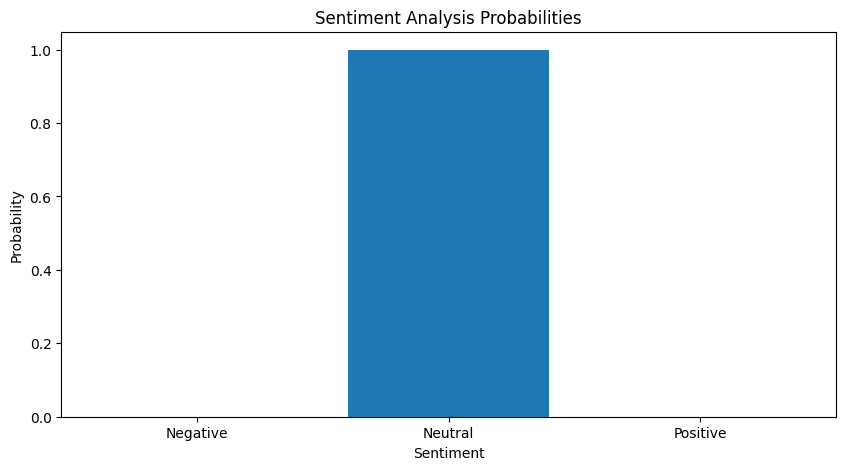

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from transformers import BertForSequenceClassification

# Specify the path to your local model
local_model_path = "fine_tuned_BERT1"

# Load the model
model = BertForSequenceClassification.from_pretrained(local_model_path)

# Function to predict sentiment
def predict_sentiment(sentence, model):
    encoded_input = tokenizer(sentence, padding=True, truncation=True, max_length=64, return_tensors='pt')
    with torch.no_grad():
        output = model(**encoded_input)
    logits = output[0]
    probabilities = F.softmax(logits, dim=1)
    predicted_label = torch.argmax(logits, dim=1).item()
    return predicted_label, probabilities[0]

# Get user input
sentence = input("Please enter a sentence for sentiment analysis: ")

# Predict label and get probabilities
predicted_label, probabilities = predict_sentiment(sentence, model)

# Display result
label_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
print("===================================")
print("       Sentiment Analysis")
print("===================================")
print(f"Input Sentence: {sentence}")
print(f"Predicted Sentiment: {label_mapping[predicted_label]}")
print("===================================")

# Convert probabilities to numpy array for plotting
probabilities = probabilities.numpy()

# Plotting
plt.figure(figsize=(10,5))
plt.bar(label_mapping.values(), probabilities)
plt.xlabel('Sentiment')
plt.ylabel('Probability')
plt.title('Sentiment Analysis Probabilities')
plt.show()


       Sentiment Analysis
Input Sentence: Synthetic Sweetener Found Inside Cake Linked To Punjab Girl's Death
Predicted Sentiment: Neutral
Probability of Negative Sentiment: 0.00
Probability of Neutral Sentiment: 1.00
Probability of Positive Sentiment: 0.00


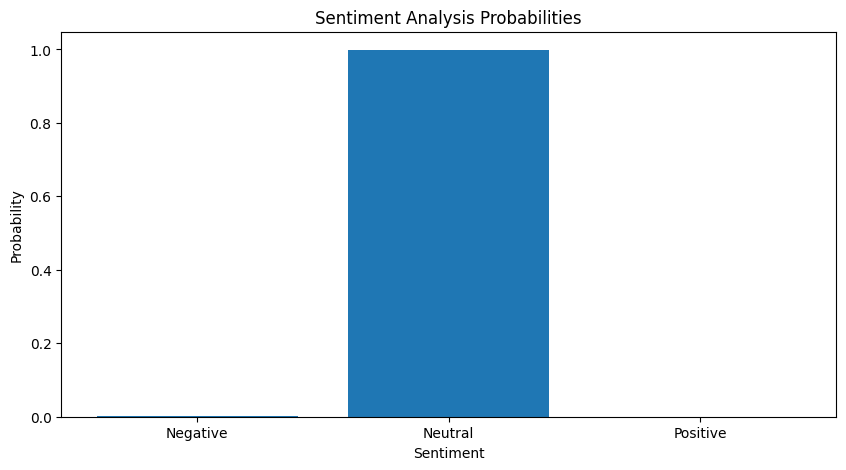

In [18]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
from transformers import BertForSequenceClassification, BertTokenizer
import torch
import warnings
warnings.filterwarnings('ignore')


# Specify the path to your local model
local_model_path = "fine_tuned_BERT1"

# Load the model
model = BertForSequenceClassification.from_pretrained(local_model_path)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')  # Updated tokenizer loading

# Function to predict sentiment
def predict_sentiment(sentence, model):
    encoded_input = tokenizer(sentence, padding=True, truncation=True, max_length=64, return_tensors='pt')
    with torch.no_grad():
        output = model(**encoded_input)
    logits = output[0]
    probabilities = F.softmax(logits, dim=1)
    predicted_label = torch.argmax(logits, dim=1).item()
    return predicted_label, probabilities[0]

# Get user input
sentence = input("Please enter a sentence for sentiment analysis: ")

# Predict label and get probabilities
predicted_label, probabilities = predict_sentiment(sentence, model)

# Extract detailed probabilities
prob_negative = probabilities[0].item()
prob_neutral = probabilities[1].item()
prob_positive = probabilities[2].item()

# Display result
label_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
print("===================================")
print("       Sentiment Analysis")
print("===================================")
print(f"Input Sentence: {sentence}")
print(f"Predicted Sentiment: {label_mapping[predicted_label]}")
print(f"Probability of Negative Sentiment: {prob_negative:.2f}")
print(f"Probability of Neutral Sentiment: {prob_neutral:.2f}")
print(f"Probability of Positive Sentiment: {prob_positive:.2f}")
print("===================================")

# Convert probabilities to numpy array for plotting
probabilities = probabilities.numpy()

# Plotting
plt.figure(figsize=(10,5))
plt.bar(label_mapping.values(), probabilities)
plt.xlabel('Sentiment')
plt.ylabel('Probability')
plt.title('Sentiment Analysis Probabilities')
plt.show()


In [2]:
import tkinter as tk
from tkinter import messagebox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure
import torch.nn.functional as F
from transformers import BertForSequenceClassification, BertTokenizer
import torch
import numpy as np

# Load the model and tokenizer
local_model_path = "fine_tuned_BERT1"
model = BertForSequenceClassification.from_pretrained(local_model_path)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to predict sentiment
def predict_sentiment(sentence):
    encoded_input = tokenizer(sentence, padding=True, truncation=True, max_length=64, return_tensors='pt')
    with torch.no_grad():
        output = model(**encoded_input)
    logits = output[0]
    probabilities = F.softmax(logits, dim=1)
    predicted_label = torch.argmax(logits, dim=1).item()
    return predicted_label, probabilities[0]

# Function to update the plot
def update_plot(probabilities):
    figure = Figure(figsize=(6, 4), dpi=100)
    subplot = figure.add_subplot(111)
    label_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
    subplot.bar(label_mapping.values(), probabilities)
    subplot.set_xlabel('Sentiment')
    subplot.set_ylabel('Probability')
    subplot.set_title('Sentiment Analysis Probabilities')

    canvas = FigureCanvasTkAgg(figure, master=root)
    canvas_widget = canvas.get_tk_widget()
    canvas_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=True)
    canvas.draw()

# Function to handle prediction
def handle_prediction():
    sentence = text_input.get("1.0", "end-1c")
    if sentence:
        predicted_label, probabilities = predict_sentiment(sentence)
        label_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
        predicted_sentiment = label_mapping[predicted_label]
        probabilities = probabilities.numpy()
        prob_negative, prob_neutral, prob_positive = probabilities
        result.set(f"Predicted Sentiment: {predicted_sentiment}\n"
                   f"Probability of Negative: {prob_negative:.2f}\n"
                   f"Probability of Neutral: {prob_neutral:.2f}\n"
                   f"Probability of Positive: {prob_positive:.2f}")
        update_plot(probabilities)
    else:
        messagebox.showwarning("Warning", "Please enter a sentence for analysis.")

# Create the main window
root = tk.Tk()
root.title("Sentiment Analysis")

# Text input for the sentence
# Text input for the sentence
text_input = tk.Text(root, height=5, width=100)  # Increased width from 50 to 70
text_input.pack(padx=10, pady=10)


# Predict button
predict_button = tk.Button(root, text="Predict Sentiment", command=handle_prediction)
predict_button.pack(pady=5)

# Result label
result = tk.StringVar()
result_label = tk.Label(root, textvariable=result, font=("Arial", 12))
result_label.pack(pady=10)

# Run the main loop
root.mainloop()
